# BLG634E - Homework 1: 3D Rotations

###  Bengisu Guresti - 504191557

## Task 1 - Plotting a 3D Object [5 pts]

### Using numpy-stl, mpl_toolkits and matplotlib libraries read the “cow.stl” and plot the 3D cow as in the Figure 1 in the instructions, using the skeleton code given.

### Read the "cow.stl" (with the skeleton code):

(5804, 9)
(5804, 3, 3)


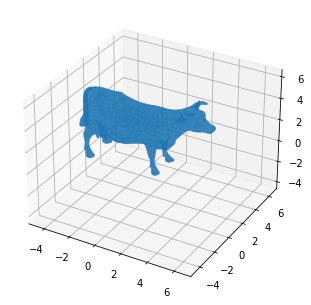

In [1]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot
import numpy as np

figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
mesh_cow = mesh.Mesh.from_file('cow.stl')
print(mesh_cow.points.shape) # (5804, 9) Each triangular face of the cow in column view
print(mesh_cow.vectors.shape) # (5804, 3, 3) Each triangular face of the cow in 3x3 view. 
                              # Each row represents a vertex.
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, alpha=0.8))
#Add the 3D faces to the created matplotlib axes
min = np.min(mesh_cow.vectors.reshape(-1))
max = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
pyplot.close()

### Use a homogenous transform matrix on each vertex to squeeze the model a bit to add a “calf” nearby the cow as given in Figure 2 in the instructions.

To add the calf nearby the cow to the right, translation is applied as transformation which is coded as translate_T (+1.5 in dx and -2.5 in dy). Scaling factor to squeeze the model is chosen as 0.5 for each dimension (x, y, z) and it is coded as scale_T. The compound transformation is obtained as squeeze_T.

In [2]:
# Translation transformation matrix defined
translate_T = np.array([[1, 0, 0, 1.5], 
                        [0, 1, 0, -2.5],
                        [0, 0, 1, 0],
                        [0, 0, 0, 1]])

# Scaling transformation matrix defined
scale_T = np.array([[0.5, 0, 0, 0], 
                    [0, 0.5, 0, 0],
                    [0, 0, 0.5, 0],
                    [0, 0, 0, 1]])

# Compound transformation matrix obtained
squeeze_T = translate_T @ scale_T

Shape of vectors from stl file of cow:

In [3]:
mesh_cow.vectors.shape

(5804, 3, 3)

Vectors of cow are expanded to 4D matrix from 3D matrix

In [4]:
COW_VECTORS = mesh_cow.vectors
COW_VECTORS = np.append(COW_VECTORS, np.ones((COW_VECTORS.shape[0], COW_VECTORS.shape[1], 1)), axis=-1)
COW_VECTORS.shape

(5804, 3, 4)

In order to apply the transform, we need to calculate $transformation \times object$. But object is properly shaped as (vector_count, point_count, point) which is the transpose of object for homogeneous transformation. Therefore instead of calculating $(transformation \times object^T)^T$, $object \times transformation^T$ is calculated in this transformation calculation and the following calculation throughout the assignment.

Calf data is obtained by transformation:

In [5]:
calf_vectors = np.matmul(COW_VECTORS, squeeze_T.T)
calf_vectors = calf_vectors[:, :, :3]
calf_vectors.shape

(5804, 3, 3)

Cow and the calf displayed and saved:

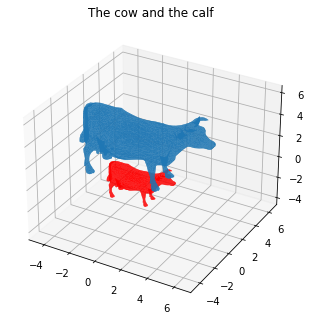

In [6]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, alpha=0.8))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(calf_vectors, alpha=0.8, facecolor='r'))
axes.set_title("The cow and the calf")
#Add the 3D faces to the created matplotlib axes
min = np.min(mesh_cow.vectors.reshape(-1))
max = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
figure.savefig('calf_with_cow')

## Task 2 - Exponential Coordinate Representation of 3D Rotations [20 pts]

### i) Start with a rotation angle of 45 degrees around z-axes. Calculate your 3x3 rotation matrix Ro, using the corresponding $w_o$ vector in R3 and using Rodrigues formula.

In [7]:
w = np.array([0, 0, 1]) # z-axis defined
t = np.pi / 4 * np.array([0, 1, 2, 3, 4, 5, 6, 7]) # list of angles for 45 degrees in between in [0, 2pi) is defined

In [8]:
# function to convert angle w to its hat operator
to_hat = lambda w : np.array([[0, -w[2], w[1]], [w[2], 0, -w[0]], [-w[1], w[0], 0]])

In [9]:
# function to convert 3x3 rotation matrix to its 4x4 equivalent
def rot4d(rot):
    rot = np.append(rot, np.zeros((3, 1)), axis=1)
    rot = np.append(rot, np.zeros((1, 4)), axis=0)
    rot[-1, -1] = 1
    return rot

In [10]:
# function to get rotation matrix by rodrigues formula
# for angle axis rotation representation (angle independent from axis)
def rodrig_t(w, t):
    """
    :param w: rotation axis
    :param t: angle (amount of rotation)
    :return: rotation matrix
    """
    w_hat = to_hat(w)
    rot = np.eye(3) + np.sin(t) * w_hat + (1 - np.cos(t)) * np.dot(w_hat, w_hat)
    rot = rot4d(rot)
    return rot

Get rotation matrices for the cow for all angles listed.

In [11]:
cow_rots = np.array([rodrig_t(w, t_i) for t_i in t])

Center of rotation is determined as object's center of mass. Therefore during rotations, it is first translated to origin from its center of mass, then rotated, and then finally translated back to its original location at its center of mass.

Center of mass of cow is obtained from its mesh properies.

In [12]:
center_of_mass = mesh_cow.get_mass_properties()[1]

Transformation to translate object to origin from the center of mass:

In [13]:
to_origin = np.eye(4)
to_origin[:3, -1] = -center_of_mass

Transformation to translate object back to its the center of mass from origin:

In [14]:
from_origin = np.eye(4)
from_origin[:3, -1] = center_of_mass

Get compound rotations for all 8 rotations:

In [15]:
final_cow_rots = from_origin @ (cow_rots @ to_origin)

Get cows as rotated with 8 rotations:

In [16]:
rotated_cows_2i = np.array([COW_VECTORS @ cow_rot.T for cow_rot in final_cow_rots])

Display and save all 8 cows superimposed (blue cow: original cow, 0 angle/no rotation):

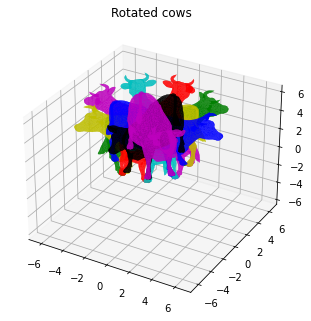

In [17]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'm']
for i, rotated_cow in enumerate(rotated_cows_2i):
    axes.add_collection3d(mplot3d.art3d.Poly3DCollection(rotated_cow[:, :, :3], alpha=0.8, facecolor=color_list[i]))
axes.set_title("Rotated cows")
#Add the 3D faces to the created matplotlib axes
min1 = np.min(mesh_cow.vectors.reshape(-1))
min2 = np.min(np.array(rotated_cows_2i).reshape(-1))
min = np.minimum(min1, min2)
max1 = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
max2 = np.max(np.array(rotated_cows_2i).reshape(-1))
max = np.maximum(max1, max2)
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
figure.savefig('cows_rotated_45')

### ii)

In [18]:
w = np.array([0.3, 0.7, -1]) # axis defined

In [19]:
# function to get rotation matrix by rodrigues formula
# for exponential coordinate representation (angle to rotate norm of axis vector)
def rodrig(w):
    """
    :param w: rotation axis
    :return: rotation matrix
    """
    w_hat = to_hat(w)
    w_norm = np.linalg.norm(w)
    rot = np.eye(3) + (w_hat / w_norm) * np.sin(w_norm) + \
          (np.dot(w_hat, w_hat) / (w_norm ** 2)) * (1 - np.cos(w_norm))
    rot = rot4d(rot)
    return rot

Get rotation matrix for the cow:

In [20]:
rot_cow = rodrig(w)

In [21]:
rot_cow

array([[ 0.34806874,  0.84858726,  0.3984317 ,  0.        ],
       [-0.6648214 ,  0.52308384, -0.53328773,  0.        ],
       [-0.66095436, -0.07926513,  0.7462281 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

Calculate composite rotation matrix (with translation to/from origin):

In [22]:
composite_rot = from_origin @ (rot_cow @ to_origin)

Obtain rotated cows:

In [23]:
rotated_cow_2ii = COW_VECTORS @ composite_rot.T

Display and save original cow: blue, rotated cow: red: 

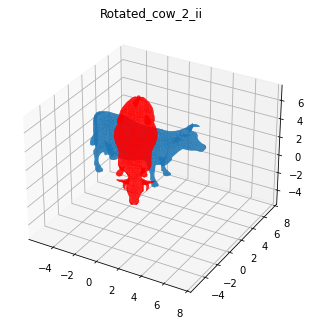

In [24]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, alpha=0.8))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(rotated_cow_2ii[:, :, :3], alpha=0.8, facecolor='r'))
axes.set_title("Rotated_cow_2_ii")
#Add the 3D faces to the created matplotlib axes
min1 = np.min(mesh_cow.vectors.reshape(-1))
min2 = np.min(rotated_cow_2ii.reshape(-1))
min = np.minimum(min1, min2)
max1 = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
max2 = np.max(rotated_cow_2ii.reshape(-1))
max = np.maximum(max1, max2)
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
figure.savefig('rotated_cow_2_ii')

In [25]:
# Function to check if center of rotation is preserved
def check_center(mesh_cow, target):
    """
    :param mesh_cow: original object mesh
    :target: rotated object vectors
    :return: True if center of rotation is preserved else False
    """
    rotated_cow_mesh_data = np.zeros(mesh_cow.vectors.shape[0], dtype=mesh.Mesh.dtype)
    rotated_cow_mesh_data['vectors'] = target
    rotated_cow_mesh = mesh.Mesh(rotated_cow_mesh_data.copy())
    mesh_center = rotated_cow_mesh.get_mass_properties()[2]
    target_center = rotated_cow_mesh.get_mass_properties()[2]
    return ((mesh_center - target_center) < 1e-7).all()

In [26]:
check_center(mesh_cow, rotated_cow_2ii[:, :, :3])

True

## Task 3: Tańcząca Polska Krowa [15 pts]

### i. Rotate your object around w1 = [1, 0.5, 0], then rotate the result around w2 = [0.3, 0.7, -1] vector. Use the norm of each w vector as the amount of radians for rotation. Show your result.

In [27]:
w1 = np.array([1, 0.5, 0]) # w1 axis defined
w2 = np.array([0.3, 0.7, -1]) # w2 axis defined

Calculate rotation matrices for w1 and w2:

In [28]:
rot_cow1 = rodrig(w1) # rotation matrix corresponding to w1
rot_cow2 = rodrig(w2) # rotation matrix corresponding to w2

Make rotation matrices composite (with translation to/from origin) with the compound rotation of first around w1 then around w2 and obtain rotated cows:

In [29]:
composite_21 = from_origin @ (rot_cow2 @ (rot_cow1 @ to_origin))
rotated_cow_twice_3i = COW_VECTORS @ composite_21.T

Display and save original cow: blue, rotated cow: red:

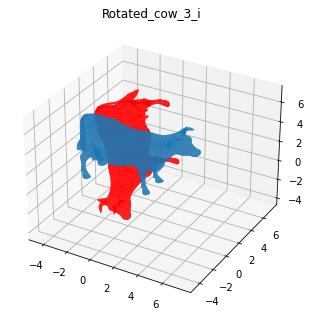

In [30]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, alpha=0.8))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(rotated_cow_twice_3i[:, :, :3], alpha=0.8, facecolor='r'))
axes.set_title("Rotated_cow_3_i")
#Add the 3D faces to the created matplotlib axes
min1 = np.min(mesh_cow.vectors.reshape(-1))
min2 = np.min(rotated_cow_twice_3i[:, :, :3].reshape(-1))
min = np.minimum(min1, min2)
max1 = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
max2 = np.max(rotated_cow_twice_3i[:, :, :3].reshape(-1))
max = np.maximum(max1, max2)
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
figure.savefig('rotated_cow_3_i')

### ii. Now rotate your object first around w2 then around w1 vector given in (i).

Make rotation matrices composite (with translation to/from origin) with the compound rotation of first around w2 then around w1 and obtain rotated cows:

In [31]:
composite_12 = from_origin @ (rot_cow1 @ (rot_cow2 @ to_origin))
rotated_cow_twice_3ii = COW_VECTORS @ composite_12.T

Display and save original cow: blue, rotated cow around w1 then w2: magenta, rotated cow around w2 then w1:red :

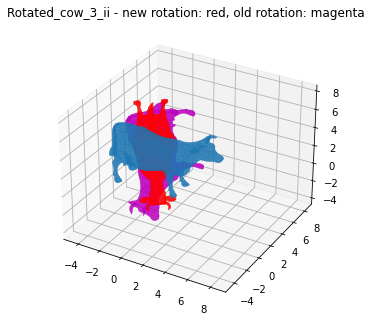

In [32]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, alpha=0.8))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(rotated_cow_twice_3i[:,:,:3], alpha=0.8, facecolor='m'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(rotated_cow_twice_3ii[:,:,:3], alpha=0.8, facecolor='r'))
axes.set_title("Rotated_cow_3_ii - new rotation: red, old rotation: magenta")
#Add the 3D faces to the created matplotlib axes
min1 = np.min(mesh_cow.vectors.reshape(-1))
min2 = np.min(rotated_cow_twice_3ii[:,:,:3].reshape(-1))
min = np.minimum(min1, min2)
max1 = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
max2 = np.max(rotated_cow_twice_3ii[:,:,:3].reshape(-1))
max = np.maximum(max1, max2)
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
figure.savefig('rotated_cow_3_ii')

Check if both rotations in i and ii give the same result object:

In [33]:
((rotated_cow_twice_3ii - rotated_cow_twice_3i) < 1e-7).all()

False

It is clear from the figure and the calculations ha objects are not obtained in the same position after (i) and (ii). Thus, 3D rotations are NOT commutative.

## Task 4: Perturbed Rotations [20 pts]

Axis vector w is chosen as: [0.4, -0.6, 0.7]. Amount to perturb his vecor is chosen as +- 5. Perturbed w axes are obtained as:

In [34]:
w_main = np.array([0.4, -0.6, 0.7]) # unperturbed axis w vector defined
p = 5 # amount to perturb
w_p = np.expand_dims(w_main, axis=0).repeat(6, axis=0)
w_p[0][0] += p
w_p[1][0] -= p
w_p[2][1] += p
w_p[3][1] -= p
w_p[4][2] += p
w_p[5][2] -= p

Rotation matrices for each perturbed w axis are calculated:

In [35]:
cow_rots_p = np.array(list(map(rodrig, w_p)))

In [36]:
cow_rots_p.shape

(6, 4, 4)

Make rotation matrices composite (with translation to/from origin):

In [37]:
composite_rot_p = from_origin @ (cow_rots_p @ to_origin)

In [38]:
composite_rot_p.shape

(6, 4, 4)

Obtain rotated cows for all 6 rotations:

In [39]:
rotated_cows_p_4 = np.array([COW_VECTORS @ rot_p.T for rot_p in composite_rot_p])

In [40]:
rotated_cows_p_4[0].shape

(5804, 3, 4)

Display and save all 6 rotated cows superimposed:

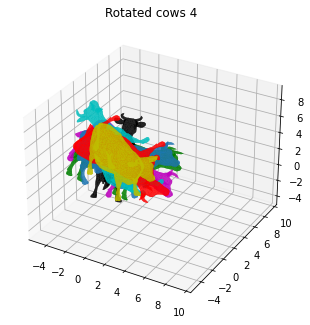

In [41]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
color_list = ['g', 'r', 'c', 'm', 'y', 'k']
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, alpha=0.8))
for i, rotated_cow in enumerate(rotated_cows_p_4):
    axes.add_collection3d(mplot3d.art3d.Poly3DCollection(rotated_cow[:,:,:3], alpha=0.8, facecolor=color_list[i]))
axes.set_title("Rotated cows 4")
#Add the 3D faces to the created matplotlib axes
min1 = np.min(mesh_cow.vectors.reshape(-1))
min2 = np.min(np.array(rotated_cows_p_4[:,:,:,:3]).reshape(-1))
min = np.minimum(min1, min2)
max1 = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
max2 = np.max(np.array(rotated_cows_p_4[:,:,:,:3]).reshape(-1))
max = np.maximum(max1, max2)
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
figure.savefig('rotated_cows_4')

## Task 5: Quaternion Representation of 3D Rotations [20 pts]

### Carry out the Task 3 by quaternions. Convert those rotations given by their axis vectors to quaternion representations q1 and q2. Carry out the consecutive quaternion multiplications to obtain the resulting quaternions and their corresponding rotation matrices. Comment on the result.


Rotation axis vectors defined:

In [42]:
w1 = np.array([1, 0.5, 0])
w2 = np.array([0.3, 0.7, -1])

Quaternion class defined:

In [43]:
rot_cow1 = rodrig(w1)
rot_cow2 = rodrig(w2)

In [44]:
class Quaternion:
    """
    Class for Quaternions
    """
    def __init__(self, w, x, y, z):
        """
        :param w: w - q_0
        :param x: x - q_1
        :param y: y - q_2
        :param z: z - q_3
        """
        self.w = w
        self.x = x
        self.y = y
        self.z = z
        
    def __mul__(self, q2):
        """
        Multiplication overloader
        :param q2: quaternion to multiply self with
        :return: self * q2
        """
        q1 = self
        w = q2.w * q1.w - q2.x * q1.x - q2.y * q1.y - q2.z * q1.z
        x = q2.w * q1.x + q2.x * q1.w - q2.y * q1.z + q2.z * q1.y
        y = q2.w * q1.y + q2.x * q1.z + q2.y * q1.w - q2.z * q1.x
        z = q2.w * q1.z - q2.x * q1.y + q2.y * q1.x + q2.z * q1.w
        return self.__class__(w, x, y, z)
    
    @classmethod
    def angleaxis_to_quaternion(cls, axis_w):
        """
        Converts exponential coordinate representation for rotations to quaternion
        :param axis_w: exponentioal coordinate representation of rotation
        :return: Quaternion equivalent of axis_w
        """
        theta = np.linalg.norm(axis_w)
        axis_w /= theta
        w = np.cos(theta/2)
        x = axis_w[0] * np.sin(theta/2)
        y = axis_w[1] * np.sin(theta/2)
        z = axis_w[2] * np.sin(theta/2)
        quat = cls(w=w, x=x, y=y, z=z)
        return quat
    
    @classmethod
    def point_to_quat(cls, p):
        """
        Converts points to quaternion
        :param q2: quaternion to multiply self with
        :return: Quaternion
        """
        return cls(0, p[0], p[1], p[2])
    
    def to_point(self):
        """
        Converts self to point
        :return: np.array
        """
        return np.array([self.x, self.y, self.z])
    
    def to_rot(self):
        q0 = self.w
        q1 = self.x
        q2 = self.y
        q3 = self.z
        return 2 * np.array([[q0 ** 2 + q1 ** 2 - 0.5, q1 * q2 - q0 * q3, q0 * q2 + q1 * q3],
                             [q0 * q3 + q1 * q2, q0 ** 2 + q2 ** 2 - 0.5, q2 * q3 - q0 * q1],
                             [q1 * q3 - q0 * q2, q0 * q1 + q2 * q3, q0 ** 2 + q3 ** 2 - 0.5]
                             ])
    
    @property
    def m(self):
        """
        Vector representation of self
        :return: np.array
        """
        return np.array([self.w, self.x, self.y, self.z])
    
    @property
    def inv(self):
        """
        Inverse of self
        :return: Quaternion
        """
        return self.__class__(w=self.w, x=-self.x, y=-self.y, z=-self.z)
    
    @property
    def conj(self):
        """
        Conjugate of self
        :return: Quaternion
        """
        return self.__class__(w=self.w, x=-self.x, y=-self.y, z=-self.z)

Convert rotation axis vectors to quaternions for w1 and w2:

In [45]:
q1 = Quaternion.angleaxis_to_quaternion(w1)
q2 = Quaternion.angleaxis_to_quaternion(w2)

In [46]:
COW_VECTORS.shape

(5804, 3, 4)

Obtain compound quaternions such that:
* q_21 represent: rotation around w1 then rotation around w2 (q2 * q1)
* q_12 represent: rotation around w2 then rotation around w1 (q1 * q2)

In [47]:
q_21 = q2 * q1
q_12 = q1 * q2

Get compound rotation matrix for q_21 and make it composite (with translation to/from origin). Then rotate the cow accordingly:

In [48]:
composite_qrot_21 = from_origin @ (rot4d(q_21.to_rot()) @ to_origin)
qrotated_cow_5i_1 = COW_VECTORS @ composite_qrot_21.T

Display and save original cow: blue, rotated cow: red:

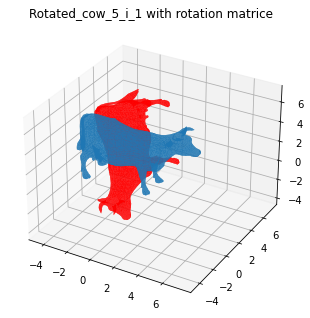

In [49]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, alpha=0.8))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(qrotated_cow_5i_1[:,:,:3], alpha=0.8, facecolor='r'))
axes.set_title("Rotated_cow_5_i_1 with rotation matrice")
#Add the 3D faces to the created matplotlib axes
min1 = np.min(mesh_cow.vectors.reshape(-1))
min2 = np.min(qrotated_cow_5i_1[:,:,:3].reshape(-1))
min = np.minimum(min1, min2)
max1 = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
max2 = np.max(qrotated_cow_5i_1[:,:,:3].reshape(-1))
max = np.maximum(max1, max2)
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
figure.savefig('rotated_cow_5_i_1_with_rot')

Instead of the previous approach, rotated the cow usign quaternion multiplication instead of getting the rotation matrix of the quaternion:

In [50]:
origin_cows = COW_VECTORS @ to_origin.T
cow_quats = list(map(Quaternion.point_to_quat, origin_cows[:,:,:3].reshape(-1,3)))
quat_cow_rot = [(q1 * cow_quat * q1.inv).to_point() for cow_quat in cow_quats]
quat_cow_rot2 = np.array([(q2 * Quaternion.point_to_quat(cow_quat) * q2.inv).to_point() for cow_quat in quat_cow_rot]).reshape(-1,3,3)
quat_cow_rot_final = np.append(quat_cow_rot2, np.ones((quat_cow_rot2.shape[0],3,1)), axis=-1)
qrotated_cow_5i_2 = quat_cow_rot_final @ from_origin.T

In [51]:
origin_cows = COW_VECTORS @ to_origin.T
cow_quats = list(map(Quaternion.point_to_quat, origin_cows[:,:,:3].reshape(-1,3)))
quat_cow_rot = [(q1 * cow_quat * q1.inv) for cow_quat in cow_quats]

Display and save original cow: blue, rotated cow: red:

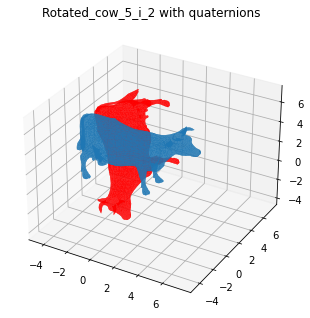

In [52]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, alpha=0.8))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(qrotated_cow_5i_2[:,:,:3], alpha=0.8, facecolor='r'))
axes.set_title("Rotated_cow_5_i_2 with quaternions")
#Add the 3D faces to the created matplotlib axes
min1 = np.min(mesh_cow.vectors.reshape(-1))
min2 = np.min(qrotated_cow_5i_2[:,:,:3].reshape(-1))
min = np.minimum(min1, min2)
max1 = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
max2 = np.max(qrotated_cow_5i_2[:,:,:3].reshape(-1))
max = np.maximum(max1, max2)
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
figure.savefig('rotated_cow_5_i_2_with_quat')

Check if the rotated cow in the first approach is the same cow as 3 (i):

In [53]:
((rotated_cow_twice_3i - qrotated_cow_5i_1) < 1e-7).all()

True

Confirmed!

Check if the rotated cow in the second approach is the same cow as 3 (i):

In [54]:
((rotated_cow_twice_3i - qrotated_cow_5i_2) < 1e-7).all()

True

Confirmed!

### ii)

Get compound rotation matrix for q_12 and make it composite (with translation to/from origin). Then rotate the cow accordingly:

In [55]:
composite_qrot_12 = from_origin @ (rot4d(q_12.to_rot()) @ to_origin)
qrotated_cow_5ii_1 = COW_VECTORS @ composite_qrot_12.T

Display and save original cow: blue, rotated cow around w1 then w2: magenta, rotated cow around w2 then w1:red :

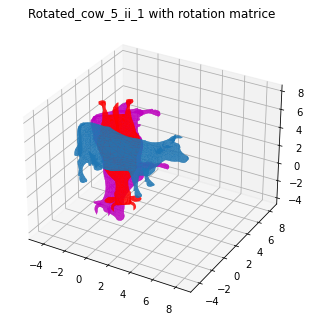

In [56]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, alpha=0.8))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(qrotated_cow_5i_1[:,:,:3], alpha=0.8, facecolor='m'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(qrotated_cow_5ii_1[:,:,:3], alpha=0.8, facecolor='r'))
axes.set_title("Rotated_cow_5_ii_1 with rotation matrice")
#Add the 3D faces to the created matplotlib axes
min1 = np.min(mesh_cow.vectors.reshape(-1))
min2 = np.min(qrotated_cow_5ii_1[:,:,:3].reshape(-1))
min = np.minimum(min1, min2)
max1 = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
max2 = np.max(qrotated_cow_5ii_1[:,:,:3].reshape(-1))
max = np.maximum(max1, max2)
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
figure.savefig('rotated_cow_5_ii_1_with_rot')

Instead of the previous approach, rotated the cow usign quaternion multiplication instead of getting the rotation matrix of the quaternion:

In [57]:
quat_cow_rot_ii = [(q2 * cow_quat * q2.inv).to_point() for cow_quat in cow_quats]
quat_cow_rot2_ii = np.array([(q1 * Quaternion.point_to_quat(cow_quat) * q1.inv).to_point() \
                          for cow_quat in quat_cow_rot_ii]).reshape(-1,3,3)
quat_cow_rot_final_ii = np.append(quat_cow_rot2_ii, np.ones((quat_cow_rot2_ii.shape[0],3,1)), axis=-1)
qrotated_cow_5ii_2 = quat_cow_rot_final_ii @ from_origin.T

Display and save original cow: blue, rotated cow around w1 then w2: magenta, rotated cow around w2 then w1:red :

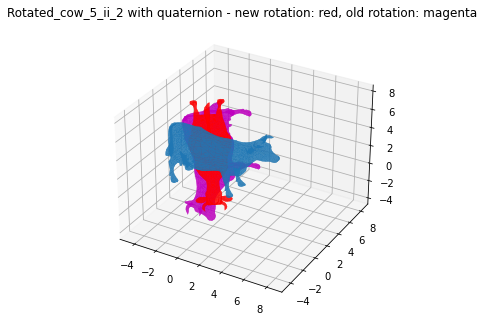

In [58]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, alpha=0.8))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(qrotated_cow_5i_2[:,:,:3], alpha=0.8, facecolor='m'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(qrotated_cow_5ii_2[:,:,:3], alpha=0.8, facecolor='r'))
axes.set_title("Rotated_cow_5_ii_2 with quaternion - new rotation: red, old rotation: magenta")
#Add the 3D faces to the created matplotlib axes
min1 = np.min(mesh_cow.vectors.reshape(-1))
min2 = np.min(qrotated_cow_5ii_2.reshape(-1))
min = np.minimum(min1, min2)
max1 = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
max2 = np.max(qrotated_cow_5ii_2.reshape(-1))
max = np.maximum(max1, max2)
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
figure.savefig('rotated_cow_5_ii_2_with_quat')

Check if the rotated cow in the first approach is the same cow as 3 (ii):

In [59]:
((rotated_cow_twice_3ii - qrotated_cow_5ii_1) < 1e-7).all()

True

Confirmed!

Check if the rotated cow in the second approach is the same cow as 3 (ii):

In [60]:
((rotated_cow_twice_3ii - qrotated_cow_5ii_2) < 1e-7).all()

True

Confirmed!

## Task 6: Explain by a few sentences [10 pts]

### I) Is there a singularity in the Exponential Coordinates? If yes, can it be overcome?

Yes there are singularities. For rotation of $|v|=\theta = 2n\pi$ where $n=1,2,3,...$ rotations are the same for the specified axis $v$ and this brings a singularity. One other singulariy is that the rotations for: rotation of $|v|=\theta$ radian, axis $\dfrac{v}{|v|}$ and $|v|=2\pi - \theta$ radian, axis $-\dfrac{v}{|v|}$ are the same. These can be overcome by restricting $\theta = |v|$ to $[0,\pi)$.

### II) Is there a singularity in Quaternions?

No there is not because it is not possible for the axes, which are fixed, to align with one-another.

### III) Why is the quaternion representation preferred over Euler angle representation for 3D rotations?

* Quaternions avoid Gimble lock and singularities unlike Euler angle representation. 
* Quaternion representation does not have discontinuity unlike Euler angle representation. 
* Quaternion representation has less computational cost than Euler angle representation because trigonometric calculations are not necessary.
* Quaternion representation has less computational cost when compounding rotations than Euler angle representation because 2 quaternion multiplication has less computational cost than 6 consecutive $3\times3$ matrix multiplications.

## Task 7: Computing Angles [10 pts]

### Read Dr. Gregory G. Slabaugh’s report titled “Computing Euler angles from a rotation matrix” . Find which Euler angles are used in the transformation matrix given below. Apply the rotation to the object
### I. Directly
### II. Using rotation matrices Rx, Ry, Rz and show that your findings are true.

Function to convert a rotation matrix to corresponding Euler angles is given below:

In [61]:
# function to convert to euler angles from rotation matrix
def rot_to_euler(rot):
    """
    :param rot: rotation matrix
    :return: theta list - list consisting of 2 alternative theta 
                          angles or one theta angle depending on rotation
             psi list - list consisting of 2 alternative psi
                        angles or one psi angle depending on rotation
             phi list - list consisting of 2 alternative phi
                        angles or one phi angle depending on rotation
    """
    theta_list = []
    psi_list = []
    phi_list = []
    if abs(rot[2, 0]) != 1: # Case 1
        theta1 = -np.arcsin(rot[2, 0])
        theta2 = np.pi - theta1
        psi1 = np.arctan2(rot[2, 1]/np.cos(theta1), rot[2, 2]/np.cos(theta1))
        psi2 = np.arctan2(rot[2, 1]/np.cos(theta2), rot[2, 2]/np.cos(theta2))
        phi1 = np.arctan2(rot[1, 0]/np.cos(theta1), rot[0, 0]/np.cos(theta1))
        phi2 = np.arctan2(rot[1, 0]/np.cos(theta2), rot[0, 0]/np.cos(theta2))
        theta_list.append(theta1)
        theta_list.append(theta2)
        psi_list.append(psi1)
        psi_list.append(psi2)
        phi_list.append(phi1)
        phi_list.append(phi2)
    else: # Case 2
        phi = 0 # can be anything defult: 0
        if rot[2, 0] == -1:
            theta = np.pi / 2
            psi = phi + np.arctan2(rot[0,1], rot[0,2])
        else:
            theta = -np.pi / 2
            psi = -phi + np.arctan2(-rot[0,1], -rot[0,2])
        theta_list.append(theta)
        psi_list.append(psi)
        phi_list.append(phi)
    return theta_list, psi_list, phi_list

Rotation matrix given in the question is defined below:

In [62]:
R = np.array([[0.8365, -0.5245, -0.1585],[0.2241, 0.5915, -0.7745],[0.5, 0.6124, 0.6124]])

Euler angles for the given rotation matrix are obtained:

In [63]:
thetas, psis, phis = rot_to_euler(R)

In [64]:
rot_to_euler(R)

([-0.5235987755982988, 3.665191429188092],
 [0.7853981633974483, -2.356194490192345],
 [0.2617553304877449, -2.8798373231020484])

As can be seen from above, there are 2 alternatives (unique in $[0, 2\pi]$). First elements in the lists are the first alternative and the second elements in the lists are the second alternative.

Function to compute rotation matrix in x axis from Euler angle psi:

In [65]:
rot_x = lambda psi : np.array([[1, 0, 0], [0, np.cos(psi), -np.sin(psi)], [0, np.sin(psi), np.cos(psi)]])

Function to compute rotation matrix in y axis from Euler angle theta:

In [66]:
rot_y = lambda theta : np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])

Function to compute rotation matrix in z axis from Euler angle phi:

In [67]:
rot_z = lambda phi : np.array([[np.cos(phi), -np.sin(phi), 0], [np.sin(phi), np.cos(phi), 0], [0, 0, 1]])

Rotation matrices in x, y, and z axes for the 2 alternatives obtained from Euler angles psis, thetas and phis:

In [68]:
R_x1, R_y1, R_z1 = rot_x(psis[0]), rot_y(thetas[0]), rot_z(phis[0])
R_x2, R_y2, R_z2 = rot_x(psis[1]), rot_y(thetas[1]), rot_z(phis[1])

Rotation matrices are converted from 3x3 to their 4x4 equivalents:

In [69]:
R, R_x1, R_y1, R_z1  = rot4d(R), rot4d(R_x1), rot4d(R_y1), rot4d(R_z1)
R_x2, R_y2, R_z2  = rot4d(R_x2), rot4d(R_y2), rot4d(R_z2)

### I. Directly

Make the provided rotation matrix composite (with translation to/from origin) and obtain the directly rotated cow:

In [70]:
composite_rot_direct = from_origin @ (R @ to_origin)
rotated_cow_direct = COW_VECTORS @ composite_rot_direct.T

Display and save original cow: blue, directly rotated cow: red:

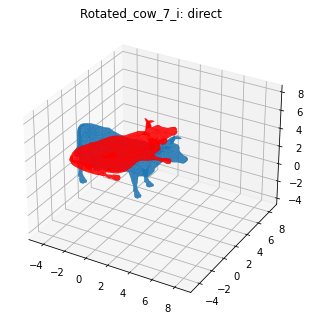

In [71]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, alpha=0.8))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(rotated_cow_direct[:, :, :3], alpha=0.8, facecolor='r'))
axes.set_title("Rotated_cow_7_i: direct")
#Add the 3D faces to the created matplotlib axes
min1 = np.min(mesh_cow.vectors.reshape(-1))
min2 = np.min(rotated_cow_direct.reshape(-1))
min = np.minimum(min1, min2)
max1 = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
max2 = np.max(rotated_cow_direct.reshape(-1))
max = np.maximum(max1, max2)
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
figure.savefig('rotated_cow_7_i')

### II. Using rotation matrices Rx, Ry, Rz.

Calculate the composite rotation matrices for the two alternatives: Compund rotation matrices are calculated by first applying the obtained rotation for x axis, then applying the obtained rotation for y axis and finally applying the obtained rotation for z axis. Then this compound rotation matrices are applied to the cows translated to the origin, then the rotation results are translated back to their original position.

In [72]:
composite_rots_euler = []
composite_rots_euler.append(from_origin @ (R_z1 @ (R_y1 @ (R_x1 @ to_origin))))
composite_rots_euler.append(from_origin @ (R_z2 @ (R_y2 @ (R_x2 @ to_origin))))
rotated_cows_euler = [COW_VECTORS @ composite_rot_euler.T for composite_rot_euler in composite_rots_euler]

Display and save original cow: blue, directly rotated cow: red, rotated cow with Euler angle rotation alternative 1: green, rotated cow with Euler angle rotation alternative 2: cyan: (only the last rotated cow will be in display because all rotated cows have the same positions)

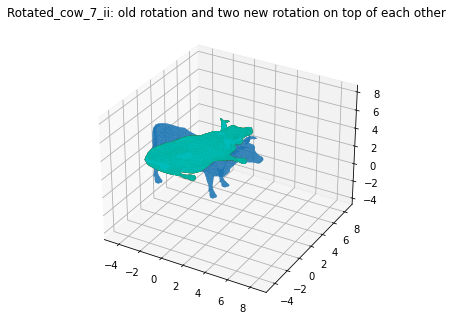

In [73]:
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
color_list = ['g', 'c', 'r', 'm', 'y', 'k', 'b', 'g']
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, alpha=0.8))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(rotated_cow_direct[:, :, :3], alpha=0.8, facecolor='r'))
for i, rotated_cow in enumerate(rotated_cows_euler):
    axes.add_collection3d(mplot3d.art3d.Poly3DCollection(rotated_cow[:,:,:3], alpha=0.8, facecolor=color_list[i]))
axes.set_title("Rotated_cow_7_ii: old rotation and two new rotation on top of each other")
#Add the 3D faces to the created matplotlib axes
min1 = np.min(mesh_cow.vectors.reshape(-1))
min2 = np.min(rotated_cow.reshape(-1))
min = np.minimum(min1, min2)
max1 = np.max(mesh_cow.vectors.reshape(-1)) # Find minimum and maximum units 
                                           # to place the cow in a cubular grid.
max2 = np.max(rotated_cow.reshape(-1))
max = np.maximum(max1, max2)
axes.auto_scale_xyz([min, max], [min, max], [min, max])
pyplot.show()
figure.savefig('rotated_cow_7_ii')

Check if the rotated cow from Euler angle rotation alternative 1 is in the same position as the rotated cow from Euler angle rotation alternative 2:

In [74]:
((rotated_cows_euler[0] - rotated_cows_euler[1]) < 1e-7).all()

True

Confirmed!

Check if the rotated cow from Euler angle rotation alternative 1 is in the same position as the directly rotated cow:

In [75]:
((rotated_cows_euler[0] - rotated_cow_direct) < 1e-3).all()

True

Confirmed! Noted: error on the order of e-4!

Check if the rotated cow from Euler angle rotation alternative 2 is in the same position as the directly rotated cow:

In [76]:
((rotated_cows_euler[1] - rotated_cow_direct) < 1e-3).all()

True

Confirmed! Noted: error on the order of e-4!

Check if the original cow object and the rotated cow from Euler angle rotation alternative 1 have the same center of mass:

In [77]:
check_center(mesh_cow, rotated_cows_euler[0][:, :, :3])

True

Confirmed!